## Семинар 8: "Снижение размерности"

ФИО:

In [31]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/user/scikit_learn_data


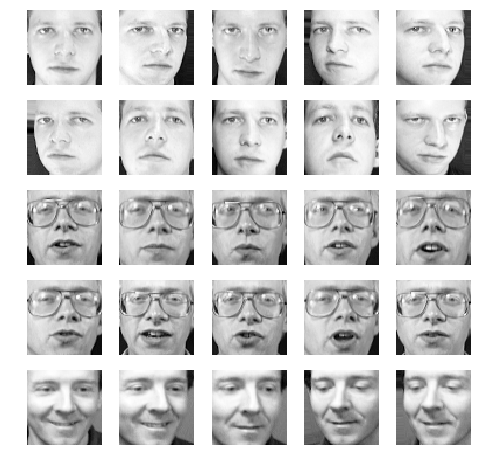

In [4]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [5]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

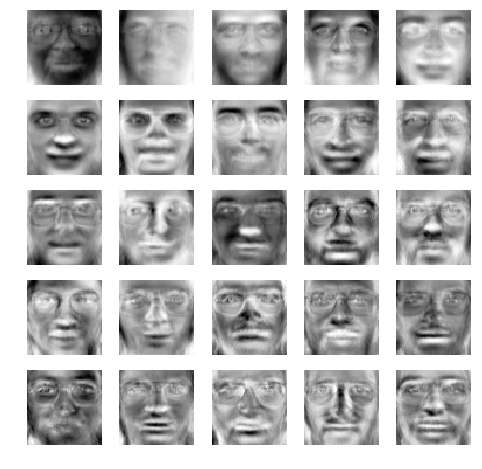

In [9]:
pca = PCA(n_components=25)

pca.fit(X)

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(pca.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

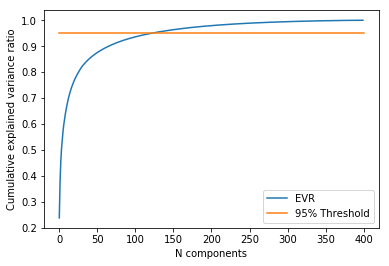

In [53]:
pca = PCA()

pca.fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='EVR')
plt.plot([0, 400], [0.95, 0.95], label='95% Threshold')
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance ratio')
plt.legend()

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [28]:
# Код для отображения изображений в 2D
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

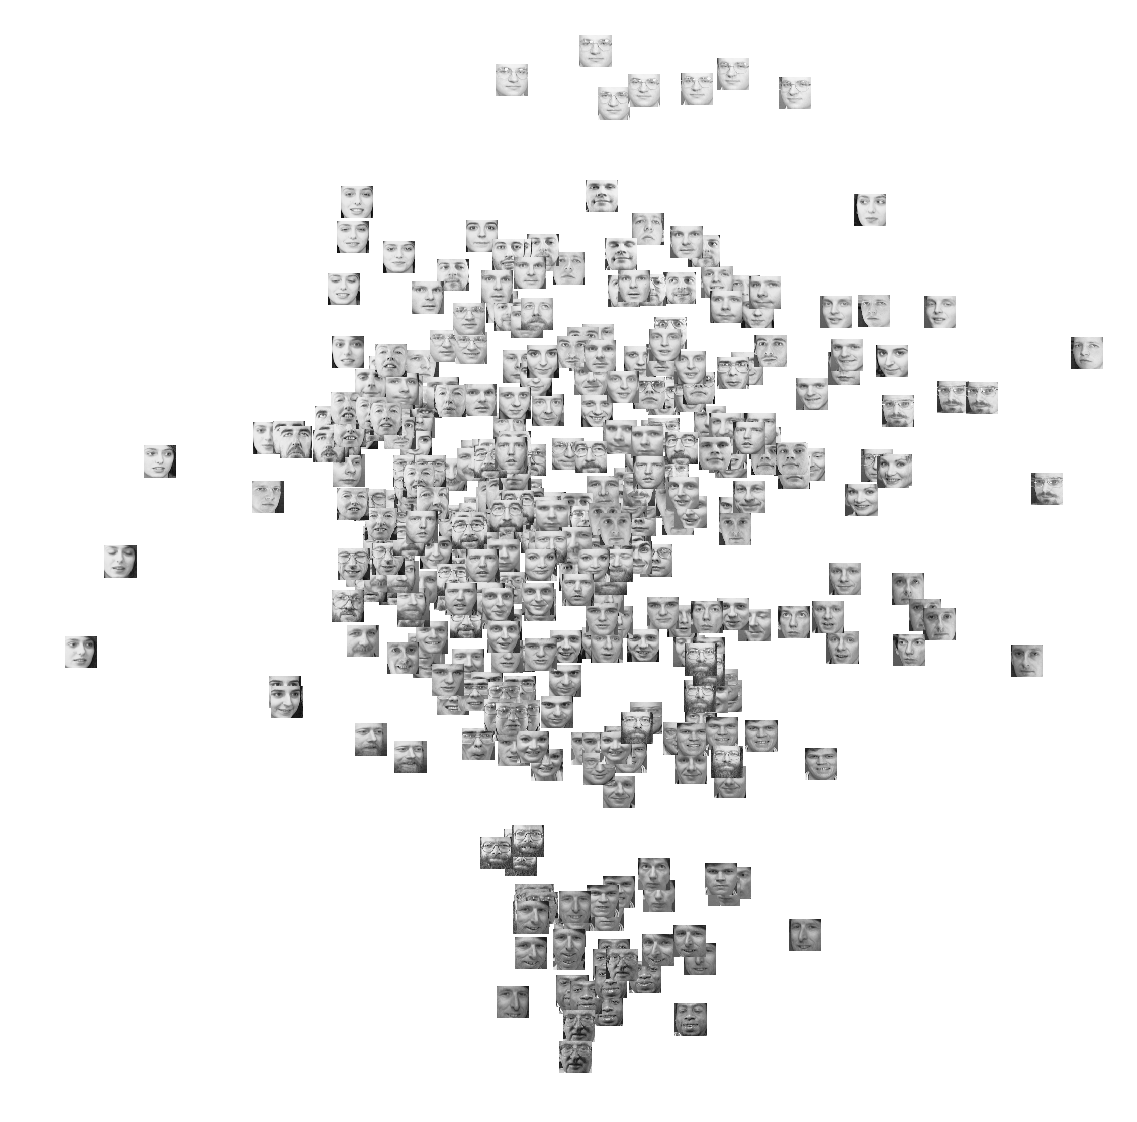

In [30]:
pca = PCA(n_components=2)

plot_dataset(X, pca.fit_transform(X), margin=50, frame=2000., imsize=64)

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [180]:
class Net(torch.nn.Module):
    def __init__(self, emb_size=10):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096, 200),
                                     nn.Sigmoid(),
                                     nn.Linear(200, emb_size),
                                     nn.Sigmoid())
        self.decoder = nn.Sequential(nn.Linear(emb_size, 200),
                                     nn.Sigmoid(),
                                     nn.Linear(200, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [143]:
model = Net(emb_size=200).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
output = model(data)

err2 = ((output-data)**2).sum()
evr = 1 - err2 / (data**2).sum()
evr.data.cpu().numpy()[0]

((output-data)**2).mean(1)
# (data**2).mean(1)

In [172]:
data = Variable(torch.from_numpy(X), requires_grad=False).cuda()
data -= data.mean(0, keepdim=True)
# del model
def scan_evr(emb_sizes):
    emb_sizes = np.rint(emb_sizes).astype('int')
    print('Testing embeddings of sizes: {}'.format(emb_sizes))
    evrs = np.zeros(shape=emb_sizes.shape)
    for i, emb_size in enumerate(emb_sizes):
        print('Testing embedding of size: {}'.format(emb_size))
        model = Net(emb_size=int(emb_size)).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for epoch in range(0, 5000):
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            if epoch % 500 == 0:
                err2 = ((output-data)**2).sum(1).mean()
                evr = 1 - err2 / (data**2).sum(1).mean()
                evr = evr.data.cpu().numpy()[0]
                print(evr)
                if evr > evrs[i]:
                    evrs[i] = evr
    return evrs

def train(epoch):
    optimizer.zero_grad()
    output = model(data)
    loss = torch.nn.functional.mse_loss(output, data)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        evr = 1 - (((output-data)**2).sum(1) / ((data)**2).sum(1)).mean().data.cpu().numpy()[0]
        print('Train Epoch: {}\tLoss: {:.6f}\tEVR:{:.6f}'.format(
            epoch, loss.data[0], evr))
        
# model.train()
# for epoch in range(1, 5000):
#     train(epoch)

<i> 2.2 Какое качество восстановления удалось получить?</i>

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [173]:
evrs = scan_evr(np.logspace(0, np.log10(400), 10))

Testing embeddings of sizes: [  1   2   4   7  14  28  54 106 206 400]
Testing embedding of size: 1
-4.70884
0.237701
0.239026
0.240714
0.245759
0.260511
0.296934
0.304656
0.305996
0.306268
Testing embedding of size: 2
-4.8191
0.374273
0.37792
0.379191
0.382045
0.390441
0.399857
0.406952
0.410258
0.412169
Testing embedding of size: 4
-4.28305
0.496355
0.507272
0.508959
0.513646
0.530392
0.552159
0.568155
0.583255
0.595629
Testing embedding of size: 7
-4.43363
0.562676
0.595916
0.600625
0.605613
0.62135
0.646464
0.674017
0.694053
0.711117
Testing embedding of size: 14
-4.47127
0.607008
0.698718
0.708947
0.715204
0.733621
0.760542
0.784859
0.802982
0.821746
Testing embedding of size: 28
-4.4938
0.632007
0.745221
0.790059
0.806484
0.815006
0.827111
0.844245
0.860402
0.873965
Testing embedding of size: 54
-4.35902
0.636191
0.762678
0.814661
0.841917
0.860709
0.877402
0.889729
0.901553
0.911892
Testing embedding of size: 106
-4.6038
0.64255
0.77915
0.831318
0.862075
0.884629
0.902088
0.9164

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

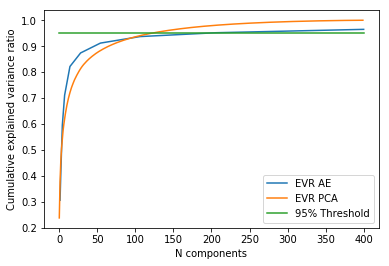

In [186]:
pca = PCA()

pca.fit(X)

plt.plot(np.rint(np.logspace(0, np.log10(400), 10)), evrs, label='EVR AE')
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='EVR PCA')
plt.plot([0, 400], [0.95, 0.95], label='95% Threshold')
plt.xlabel('N components')
plt.ylabel('Cumulative explained variance ratio')
plt.legend()

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [192]:
model = Net(emb_size=2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
for epoch in range(0, 5000):
    optimizer.zero_grad()
    output = model(data)
    loss = torch.nn.functional.mse_loss(output, data)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        err2 = ((output-data)**2).sum(1).mean()
        evr = 1 - err2 / (data**2).sum(1).mean()
        evr = evr.data.cpu().numpy()[0]
        print(evr)

-4.55101
0.375918
0.37853
0.380413
0.386411
0.397292
0.405824
0.409726
0.413992
0.418589


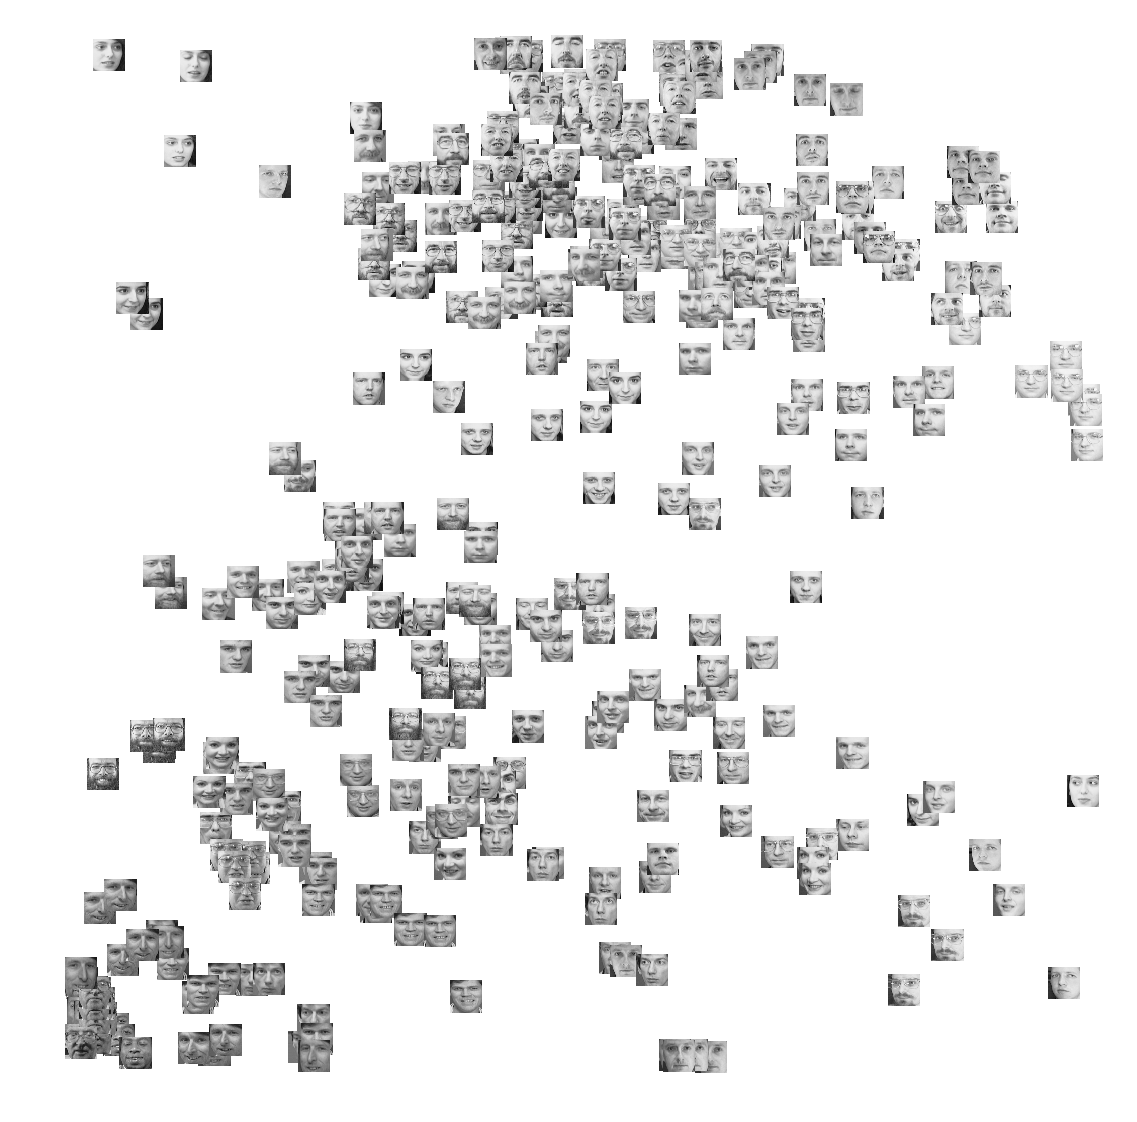

In [193]:
output = model.encoder(data).data.cpu().numpy()

plot_dataset(X, output, margin=50, frame=2000., imsize=64)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: